In [16]:
import scipy as sp
import numpy as np
import pandas as pd
import multiprocessing as mp
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor

D=pd.read_csv("https://raw.githubusercontent.com/AnnaDS/tangramm/master/tangramm_test.csv")

D.columns=[x.strip() for x in D.columns]

print("Data split.")
Dtrain=D[D['test']==0]
Dtest=D[D['test']==1]
#r=list(D.columns-['test', 'class'])
r=list(D.columns.difference(['test', 'class']))
#Data frame of train samples
Dtrain_x=Dtrain[r]
#Data frame of test samples
Dtest_x=Dtest[r]

scaler = StandardScaler()
y_train=Dtrain['class']
y_test=Dtest['class']
#Feature's names
features=Dtest_x.columns

#Scale of features (standartization)
scaler.fit(Dtrain_x)  # Don't cheat - fit only on training data
X_train = scaler.transform(Dtrain_x)
X_test = scaler.transform(Dtest_x)  



def find_indices(lst, condition):
    return [i for i, elem in enumerate(lst) if condition(elem)]
def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = metrics.mutual_info_score(None, None, contingency=c_xy)
    return mi
    
comp=[x/10 for x in range(1,10)]
k=0
best=pd.DataFrame()
#best=best.append(pd.Series({'model':'Random Forest', 'estimator':gs_rfr.best_estimator_, 'score': gs_rfr.best_score_, 'params':gs_rfr.best_params_}), ignore_index=True)
for k in comp:
    scores=[]
    for i in range(0,len(features)):
        s = calc_MI(list(zip(*X_train))[i], list(y_train), 10)
        scores.append(s)
    
    mii=find_indices(np.array(scores), lambda e: e > k)
    if len(mii)<2 :
        break
    X_train_mi=X_train[:,mii]
    X_test_mi=X_test[:,mii]
    features_mi=features[mii]
    
    print("CV starts.")    
    #Support vector regression
    svr = svm.SVR()   
    param_grid = [{'alpha' : 10.0**-np.arange(1,7),'l1_ratio':[.05, .15, .5, .7, .9, .95, .99, 1]}]
    parameters_svr = {'kernel':('linear', 'rbf'), 'C':list(range(1, 100))}
    gs_svr = GridSearchCV(svr,parameters_svr,n_jobs=8,verbose=1)
    gs_svr.fit(X_train_mi, y_train)
    best=best.append(pd.Series({'model':'SVR', 'k':k,'estimator':gs_svr.best_estimator_, 'score': gs_svr.best_score_, 'params':gs_svr.best_params_}), ignore_index=True)

    #Kernel Ridge regression
    kr=KernelRidge()
    parameters_kr = { 'gamma': [0.01, 0.001, 0.0001], 'kernel': ('linear', 'rbf')}
    gs_kr = GridSearchCV(kr,parameters_kr,n_jobs=8,verbose=1)
    gs_kr.fit(X_train_mi, y_train)
    best=best.append(pd.Series({'model':'KernelRidge', 'k':k,'estimator':gs_kr.best_estimator_, 'score': gs_kr.best_score_, 'params':gs_kr.best_params_}), ignore_index=True)

    #Random Forest regression
    rfr=RandomForestRegressor()
    parameters_rfr = {'n_estimators': [500, 700, 1000, 10000], 'max_depth': [None, 1, 2, 3, 4, 5,6], 'min_samples_split': [1, 2, 3]}
    gs_rfr = GridSearchCV(rfr,parameters_rfr,n_jobs=8,verbose=1)
    gs_rfr.fit(X_train_mi, y_train)
    best=best.append(pd.Series({'model':'RandomForest', 'k':k,'estimator':gs_rfr.best_estimator_, 'score': gs_rfr.best_score_, 'params':gs_rfr.best_params_}), ignore_index=True)


#Select best options fom model selections according to the results using list of models and parameters

V=best.score.tolist().index(max(best.score))
BV=best.ix[[V]]
mii=find_indices(np.array(scores), lambda e: e > float(BV.k))

X_train_mi=X_train[:,mii]
X_test_mi=X_test[:,mii]
features_mi=features[mii]
s = BV.estimator.tolist()[0]#svm.SVR(C=99, kernel='linear')
s.fit(X_train_mi, y_train)
    
print("Selected model with params:")
print(str(BV.estimator.tolist()[0]))
print("Best score on the train data:")
print(s.score(X_train_mi, y_train))
print("Best score on test data:")
print(s.score(X_test_mi, y_test.values))
print("MSE of prediction:")
print(np.average(abs(s.predict(X_test_mi)-y_test.values)**2))
print("Average relative accuracy:")
print(100-np.average(abs((s.predict(X_test_mi)-y_test.values)/y_test.values)))

Data split.
CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.6s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   49.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.8min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  5.6min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   43.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.5min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  5.2min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   42.2s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed: 18.7min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed: 27.6min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   38.9s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  5.1min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   35.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.3min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  4.7min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    0.5s finished


Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   31.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  4.9min finished


CV starts.
Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 594 out of 594 | elapsed:    1.2s finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits
Fitting 3 folds for each of 84 candidates, totalling 252 fits


[Parallel(n_jobs=8)]: Done  18 out of  18 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   39.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  3.4min
[Parallel(n_jobs=8)]: Done 252 out of 252 | elapsed:  4.7min finished


Selected model with params:
SVR(C=99, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Best score on the train data:
0.372405550961
Best score on test data:
-0.191549807322
MSE of prediction:
237771216.606
Average relative accuracy:
99.5629415324


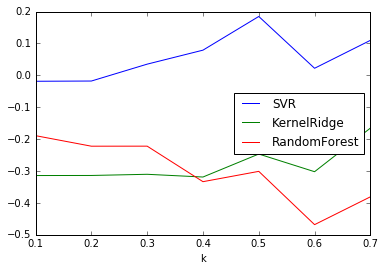

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline 
result = pd.merge(best[best.model=='SVR'][['k','score']], best[best.model=='KernelRidge'][['k','score']], on='k')
result = pd.merge(result, best[best.model=='RandomForest'][['k','score']], on='k')
result=result.set_index(result.k)
result.columns=['k','SVR', 'KernelRidge', 'RandomForest']
result=result[['SVR', 'KernelRidge', 'RandomForest']]
result.plot()

In [46]:


D.head()
y_train_pred=s.predict(X_train_mi)
y_test_pred=s.predict(X_test_mi)
#plt.plot(np.array(scores))

(array([ 382.,  316.,  193.,   53.,   15.,    8.,    8.,    2.,    0.,    6.]),
 array([  4.48673263e-04,   2.70715306e+01,   5.41426125e+01,
          8.12136945e+01,   1.08284776e+02,   1.35355858e+02,
          1.62426940e+02,   1.89498022e+02,   2.16569104e+02,
          2.43640186e+02,   2.70711268e+02]),
 <a list of 10 Patch objects>)

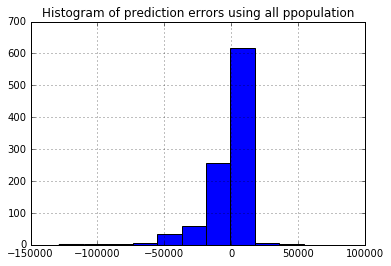

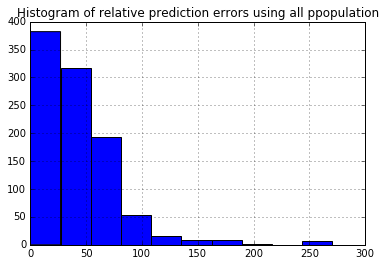

In [64]:
D_res=D
D_res['prediction']=np.concatenate([y_train_pred, y_test_pred])
D_res['error']=D_res['prediction']-D_res['class']
D_res['relative_error']=100*abs(D_res['error']/D_res['class'])
plt.hist(D_res['error'])
plt.title('Histogram of prediction errors using all ppopulation')
plt.grid(True)
plt.figure()
plt.title('Histogram of relative prediction errors using all ppopulation')
plt.grid(True)
plt.hist(D_res['relative_error'])

In [58]:
error=D_res['prediction']-D_res['class']

In [56]:
len(np.concatenate([y_train_pred, y_test_pred]))

983